<a href="https://colab.research.google.com/github/larrygoyeau/Lanit-Tercom/blob/master/%D0%A1%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0_kaggle_Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация летательных аппартатов.


Перед вами стоит задача написать свою сеточку без использования предобученных. Нашей целью будет научиться классифицировать летательные аппараты в небе, такие как самолет, джет, дрон, вертолет и ракета. 



 ![alt text](https://i.mycdn.me/i?r=AzF-kPXTZw6IaWs3aSUGrfjPqUvSFXbXZjS9ETU_SPXIDPRCu6D2qclJT0qwJlg-gZA)






Для того, чтобы сохранить вес модели, подключить drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Изображения импортируются.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1pvsgHExIgPqpJeoW6vp8RziMfskLS5qW',
                                    dest_path='/content/data.zip',
                                    unzip=True)

In [ ]:
import numpy as np
import pandas as pd
import torch

import PIL

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import pickle
import numpy as np
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# мы будем игнорировать warnings, так как вы блокнотах в sklearn не все бывает гладко
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

### Пример аугментаций

Самым важным преобразованием для увеличения данных является «RandomErasing»: случайным образом выбирает прямоугольную область на изображении и стирает ее пиксели. Это позволит избежать переобучения.

In [ ]:
class PlanesDataset(Dataset):
  def __init__(self, files, mode, augmentations = False):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    if self.augmentations==True:
      transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), interpolation=3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=20,translate=(0.12,0.12),resample=PIL.Image.NEAREST,fillcolor=20),
        transforms.RandomPerspective(distortion_scale=0.25,),
        transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=1,hue=0.10),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.75, scale=(0.02, 0.2)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
      ])
    else:
        transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
      ])

    x = self.load_sample(self.files[index])
    #x = self._prepare_sample(x)

    x=np.array(x)
    #x = np.array(x / 255, dtype='float32')

    x = transform(x)
  
    if self.mode == 'test':
      return x
    else:        
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split
from pathlib import PosixPath

# делим тренировочный сет на валидационный и тренировочный 30/70

train_val_labels = [path.parent.name for path in train_val_files]

'''
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

f = open("/content/drive/My Drive/train_files.txt", "w")
f.write(str(train_files))
f.close()
g = open("/content/drive/My Drive/val_files.txt", "w")
g.write(str(val_files))
g.close() '''

'\ntrain_files, val_files = train_test_split(train_val_files, test_size=0.3,                                           stratify=train_val_labels)\n\nf = open("/content/drive/My Drive/train_files.txt", "w")\nf.write(str(train_files))\nf.close()\ng = open("/content/drive/My Drive/val_files.txt", "w")\ng.write(str(val_files))\ng.close() '

Разделение между обучающим набором и проверочным набором сохраняется. Это позволило мне переобучить модель на тех же данных.

In [ ]:
with open("/content/drive/My Drive/train_files.txt", "r") as f:
  train_files=eval(f.read())

with open("/content/drive/My Drive/val_files.txt", "r") as f:
  val_files=eval(f.read())

In [ ]:
val_dataset = PlanesDataset(val_files, mode='val',augmentations=False)
train_dataset = PlanesDataset(train_files, mode='train',augmentations=True)

# Изучаем данные

In [ ]:
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

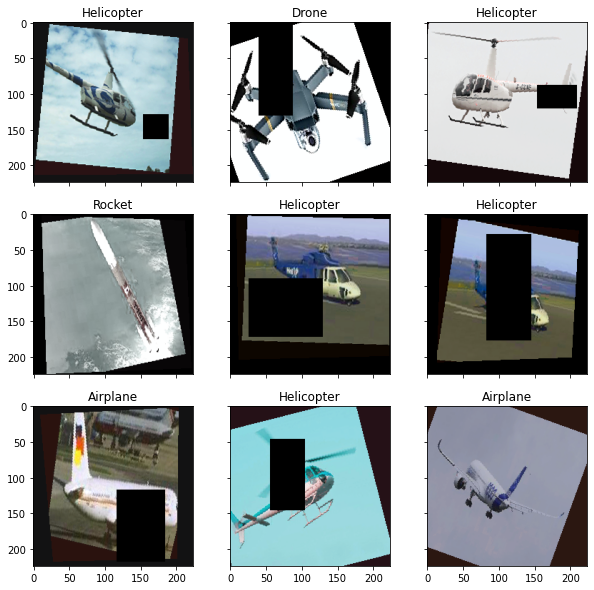

In [ ]:
# выведем некоторые изображения
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,200))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Нейронная сеть: ResNet50

In [ ]:
from functools import partial

class Conv2d_Auto_Padding(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv_3x3 = partial(Conv2d_Auto_Padding, kernel_size=3, bias=False)

class Residual_Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.in_channel=in_channel
        self.out_channel =  out_channel
        self.shortcut = nn.Identity() 
        self.blocks = nn.Identity()  
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut:
          residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channel != self.out_channel

In [ ]:
from collections import OrderedDict

class ResNet_Residual_Block(Residual_Block):
    def __init__(self, in_channel, out_channel, downsampling=1, features_expansion=1, conv=conv_3x3, *args, **kwargs):
        super().__init__(in_channel, out_channel)
        self.downsampling= downsampling
        self.features_expansion= features_expansion
        self.conv = conv
        if self.should_apply_shortcut:
          self.shortcut = nn.Sequential(OrderedDict(
          {
              'conv' : nn.Conv2d(self.in_channel, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
              'bn' : nn.BatchNorm2d(self.expanded_channels)
          }))
        else:
          self.shortcut =None
        
        
    @property
    def expanded_channels(self):
        return self.out_channel * self.features_expansion

    @property
    def should_apply_shortcut(self):
        return self.in_channel != self.expanded_channels

def conv_BatchNorm2d(in_channel, out_channel, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channel, out_channel, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channel) }))

Блоки BottleNeck для ResNet:

<img src='https://drive.google.com/uc?export=view&id=1EfXfsElgIIdFcsTebxmKDCU5fa1M9ZW4' width="300">



Слой ResNet состоит из блоков, уложенных один за другим.

<img src='https://drive.google.com/uc?export=view&id=1z-clgvPybDdT64HMahsrGIJjlTIJaWn3' width="800">

Мы можем легко определить это, просто вставив n блоков один за другим.




In [ ]:
class ResNetBottleneck(ResNet_Residual_Block):
    features_expansion = 4
    def __init__(self, in_channel, out_channel, *args, **kwargs):
        super().__init__(in_channel, out_channel, features_expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_BatchNorm2d(self.in_channel, self.out_channel, self.conv, kernel_size=1),
             nn.ReLU(),
             conv_BatchNorm2d(self.out_channel, self.out_channel, self.conv, kernel_size=3, stride=self.downsampling),
             nn.ReLU(),
             conv_BatchNorm2d(self.out_channel, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNet_Layer(nn.Module):
    def __init__(self, in_channel, out_channel, nbr_block=1, *args, **kwargs):
        super().__init__()
        # Мы выполняем понижающую дискретизацию непосредственно сверточными слоями с шагом 2.'
        if in_channel != out_channel:
          downsampling = 2
        else:
          downsampling= 1
        # Заклеил nbr_block ResNetBottleneck блоков один за другим
        self.blocks = nn.Sequential(
            ResNetBottleneck(in_channel , out_channel, *args, **kwargs, downsampling=downsampling),
            *[ResNetBottleneck(out_channel * ResNetBottleneck.features_expansion, 
                    out_channel, downsampling=1, *args, **kwargs) for _ in range(nbr_block - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [ ]:
class ResNet_Encoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channel=3, distribution_nbr_block=[2,2,2,2], *args,**kwargs):
        super().__init__()
        
        distribution_nbr_channel = [64, 128, 256, 512]
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channel, distribution_nbr_channel[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(distribution_nbr_channel[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_channel = list(zip(distribution_nbr_channel, distribution_nbr_channel[1:]))
        self.blocks = nn.ModuleList([ 
            ResNet_Layer(distribution_nbr_channel[0], distribution_nbr_channel[0],
                         nbr_block=distribution_nbr_block[0], *args, **kwargs),
            *[ResNet_Layer(in_channel * ResNetBottleneck.features_expansion, 
                          out_channel, nbr_block=nbr_block, activation=nn.ReLU, 
                          block=ResNetBottleneck, *args, **kwargs)
              for (in_channel, out_channel), nbr_block in zip(self.in_out_channel, distribution_nbr_block[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
class Resnet_Decoder(nn.Module):
    """
   Resnet Decoder выполняет average pooling, за которым следует полностью связанный слой для вывода класса.
    """
    def __init__(self, in_dimension, nbr_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_dimension, nbr_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    
    def __init__(self, in_channel, nbr_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNet_Encoder(in_channel, *args, **kwargs)
        self.decoder = Resnet_Decoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, nbr_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet50(in_channel, nbr_classes):
    return ResNet(in_channel, nbr_classes, distribution_nbr_block=[3, 4, 6, 3])

Функции для обучения и оценки модели. Тут можно поиграться с learning rate, добавить для него scheduler, который будет его варьировать.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size,learning_rate,best_acc):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Здесь можно добавить схему изменения learning rate
        
        opt = torch.optim.Adam(model.parameters(),lr=learning_rate)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), '/content/drive/My Drive/summer-school-2020/Resnet50.pth')
                
    print('Best val Acc: {:4f}'.format(best_acc))
    
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Создадим модель, проверим, что в ней те слои, которые нам нужны.

In [ ]:
n_classes = len(np.unique(train_val_labels))
model = resnet50(3,n_classes).to(DEVICE)
best_acc=0
print(model)
batch_size=32

ResNet(
  (encoder): ResNet_Encoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNet_Layer(
        (blocks): Sequential(
          (0): ResNetBottleneck(
            (shortcut): Sequential(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2d_Auto_Padding(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1):

# Тренировка

Запустим модель. Обрати внимание, что результат (и score) может немного отличаться в зависимости от batch_size.
Тут можно поменять на большее количество эпох. Но не переобучись!

In [ ]:
history = train(train_dataset, 
                val_dataset,
                model=model, 
                epochs=100,
                batch_size=batch_size,
                learning_rate=0.0001,
                best_acc=best_acc)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

loss 1.49975642090752


epoch:   1%|          | 1/100 [01:40<2:46:11, 100.72s/it]


Epoch 001 train_loss: 1.4998     val_loss 1.2406 train_acc 0.3900 val_acc 0.5000
loss 1.6595271233149937


epoch:   2%|▏         | 2/100 [03:22<2:44:56, 100.99s/it]


Epoch 002 train_loss: 1.6595     val_loss 1.2661 train_acc 0.3457 val_acc 0.4244
loss 1.38833307379768


epoch:   3%|▎         | 3/100 [05:03<2:43:34, 101.18s/it]


Epoch 003 train_loss: 1.3883     val_loss 1.1929 train_acc 0.4171 val_acc 0.5111
loss 1.3335977007093884


epoch:   4%|▍         | 4/100 [06:46<2:42:17, 101.44s/it]


Epoch 004 train_loss: 1.3336     val_loss 1.1611 train_acc 0.4343 val_acc 0.5400
loss 1.2481177920386906


epoch:   5%|▌         | 5/100 [08:26<2:40:09, 101.15s/it]


Epoch 005 train_loss: 1.2481     val_loss 1.0289 train_acc 0.4767 val_acc 0.5644
loss 1.090732877935682


epoch:   6%|▌         | 6/100 [10:07<2:38:19, 101.06s/it]


Epoch 006 train_loss: 1.0907     val_loss 0.9094 train_acc 0.5533 val_acc 0.6256
loss 1.0461062756038848


epoch:   7%|▋         | 7/100 [11:48<2:36:38, 101.06s/it]


Epoch 007 train_loss: 1.0461     val_loss 1.0269 train_acc 0.5600 val_acc 0.6344
loss 0.9628953379676456


epoch:   8%|▊         | 8/100 [13:29<2:35:08, 101.17s/it]


Epoch 008 train_loss: 0.9629     val_loss 0.7512 train_acc 0.6081 val_acc 0.7078
loss 0.9219293186778114


epoch:   9%|▉         | 9/100 [15:10<2:33:10, 100.99s/it]


Epoch 009 train_loss: 0.9219     val_loss 0.9091 train_acc 0.6248 val_acc 0.6233
loss 0.907522026243664


epoch:  10%|█         | 10/100 [16:49<2:30:43, 100.49s/it]


Epoch 010 train_loss: 0.9075     val_loss 0.6648 train_acc 0.6381 val_acc 0.7433
loss 0.8344313099270775


epoch:  11%|█         | 11/100 [18:29<2:28:31, 100.13s/it]


Epoch 011 train_loss: 0.8344     val_loss 0.7332 train_acc 0.6562 val_acc 0.7022
loss 0.8021086968694414


epoch:  12%|█▏        | 12/100 [20:07<2:26:19, 99.77s/it]


Epoch 012 train_loss: 0.8021     val_loss 0.6358 train_acc 0.6781 val_acc 0.7789
loss 0.8215447702861968


epoch:  13%|█▎        | 13/100 [21:47<2:24:44, 99.82s/it]


Epoch 013 train_loss: 0.8215     val_loss 0.6619 train_acc 0.6795 val_acc 0.7533
loss 0.713982999211266


epoch:  14%|█▍        | 14/100 [23:26<2:22:21, 99.32s/it]


Epoch 014 train_loss: 0.7140     val_loss 0.6518 train_acc 0.7129 val_acc 0.7756
loss 0.7807997641109284


epoch:  15%|█▌        | 15/100 [25:03<2:19:43, 98.62s/it]


Epoch 015 train_loss: 0.7808     val_loss 0.7195 train_acc 0.6976 val_acc 0.7467
loss 0.7211639953794934


epoch:  16%|█▌        | 16/100 [26:41<2:18:04, 98.63s/it]


Epoch 016 train_loss: 0.7212     val_loss 0.5639 train_acc 0.7243 val_acc 0.8044
loss 0.6555503504616874


epoch:  17%|█▋        | 17/100 [28:20<2:16:35, 98.74s/it]


Epoch 017 train_loss: 0.6556     val_loss 0.6190 train_acc 0.7462 val_acc 0.7711
loss 0.6996261797064827


epoch:  18%|█▊        | 18/100 [30:00<2:15:19, 99.02s/it]


Epoch 018 train_loss: 0.6996     val_loss 0.5470 train_acc 0.7343 val_acc 0.8133
loss 0.6279065769059318


epoch:  19%|█▉        | 19/100 [31:40<2:14:10, 99.39s/it]


Epoch 019 train_loss: 0.6279     val_loss 0.5325 train_acc 0.7576 val_acc 0.8211
loss 0.6921495384261722


epoch:  20%|██        | 20/100 [33:21<2:13:01, 99.77s/it]


Epoch 020 train_loss: 0.6921     val_loss 0.6048 train_acc 0.7262 val_acc 0.7733
loss 0.5829471786816914


epoch:  21%|██        | 21/100 [35:00<2:11:20, 99.75s/it]


Epoch 021 train_loss: 0.5829     val_loss 0.4639 train_acc 0.7767 val_acc 0.8444
loss 0.5681035461879912


epoch:  22%|██▏       | 22/100 [36:41<2:10:09, 100.12s/it]


Epoch 022 train_loss: 0.5681     val_loss 0.5261 train_acc 0.7905 val_acc 0.8089
loss 0.5402464512983958


epoch:  23%|██▎       | 23/100 [38:22<2:08:36, 100.21s/it]


Epoch 023 train_loss: 0.5402     val_loss 0.4964 train_acc 0.7981 val_acc 0.8378
loss 0.5493183944338844


epoch:  24%|██▍       | 24/100 [40:02<2:06:59, 100.26s/it]


Epoch 024 train_loss: 0.5493     val_loss 0.4487 train_acc 0.7910 val_acc 0.8544
loss 0.525182527019864


epoch:  25%|██▌       | 25/100 [41:43<2:05:34, 100.46s/it]


Epoch 025 train_loss: 0.5252     val_loss 0.5362 train_acc 0.7990 val_acc 0.8400
loss 0.4939209336893899


epoch:  26%|██▌       | 26/100 [43:24<2:03:57, 100.51s/it]


Epoch 026 train_loss: 0.4939     val_loss 0.4308 train_acc 0.8071 val_acc 0.8556
loss 0.46813770998091925


epoch:  27%|██▋       | 27/100 [45:05<2:02:30, 100.70s/it]


Epoch 027 train_loss: 0.4681     val_loss 0.4893 train_acc 0.8148 val_acc 0.8122
loss 0.47928710971559796


epoch:  28%|██▊       | 28/100 [46:45<2:00:37, 100.52s/it]


Epoch 028 train_loss: 0.4793     val_loss 0.5029 train_acc 0.8143 val_acc 0.8311
loss 0.48954979101816815


epoch:  29%|██▉       | 29/100 [48:25<1:58:49, 100.41s/it]


Epoch 029 train_loss: 0.4895     val_loss 0.4123 train_acc 0.8129 val_acc 0.8578
loss 0.4578433975151607


epoch:  30%|███       | 30/100 [50:06<1:57:19, 100.57s/it]


Epoch 030 train_loss: 0.4578     val_loss 0.4038 train_acc 0.8252 val_acc 0.8756
loss 0.4129911729267665


epoch:  31%|███       | 31/100 [51:46<1:55:34, 100.49s/it]


Epoch 031 train_loss: 0.4130     val_loss 0.3930 train_acc 0.8519 val_acc 0.8678
loss 0.44317092884154546


epoch:  32%|███▏      | 32/100 [53:27<1:53:51, 100.46s/it]


Epoch 032 train_loss: 0.4432     val_loss 0.3801 train_acc 0.8390 val_acc 0.8833
loss 0.4225912619772412


epoch:  33%|███▎      | 33/100 [55:08<1:52:16, 100.54s/it]


Epoch 033 train_loss: 0.4226     val_loss 0.3527 train_acc 0.8448 val_acc 0.8867
loss 0.4124323767139798


epoch:  34%|███▍      | 34/100 [56:49<1:50:58, 100.88s/it]


Epoch 034 train_loss: 0.4124     val_loss 0.3471 train_acc 0.8476 val_acc 0.8889
loss 0.37263404820646556


epoch:  35%|███▌      | 35/100 [58:31<1:49:33, 101.14s/it]


Epoch 035 train_loss: 0.3726     val_loss 0.4894 train_acc 0.8638 val_acc 0.8489
loss 0.42101988179343086


epoch:  36%|███▌      | 36/100 [1:00:11<1:47:39, 100.93s/it]


Epoch 036 train_loss: 0.4210     val_loss 0.4095 train_acc 0.8414 val_acc 0.8756
loss 0.4107310355277288


epoch:  37%|███▋      | 37/100 [1:01:51<1:45:38, 100.60s/it]


Epoch 037 train_loss: 0.4107     val_loss 0.3700 train_acc 0.8567 val_acc 0.8878
loss 0.3926947425660633


epoch:  38%|███▊      | 38/100 [1:03:31<1:43:39, 100.32s/it]


Epoch 038 train_loss: 0.3927     val_loss 0.5042 train_acc 0.8548 val_acc 0.8456
loss 0.4045132804058847


epoch:  39%|███▉      | 39/100 [1:05:11<1:41:51, 100.18s/it]


Epoch 039 train_loss: 0.4045     val_loss 0.4169 train_acc 0.8486 val_acc 0.8611
loss 0.3863454828375862


epoch:  40%|████      | 40/100 [1:06:51<1:40:14, 100.24s/it]


Epoch 040 train_loss: 0.3863     val_loss 0.4558 train_acc 0.8595 val_acc 0.8644
loss 0.35651841367994036


epoch:  41%|████      | 41/100 [1:08:30<1:38:17, 99.96s/it]


Epoch 041 train_loss: 0.3565     val_loss 0.4262 train_acc 0.8667 val_acc 0.8778
loss 0.3682748564084371


epoch:  42%|████▏     | 42/100 [1:10:10<1:36:22, 99.70s/it]


Epoch 042 train_loss: 0.3683     val_loss 0.3335 train_acc 0.8624 val_acc 0.8944
loss 0.38271159932726906


epoch:  43%|████▎     | 43/100 [1:11:49<1:34:34, 99.55s/it]


Epoch 043 train_loss: 0.3827     val_loss 0.3335 train_acc 0.8600 val_acc 0.9000
loss 0.3424500872407641


epoch:  44%|████▍     | 44/100 [1:13:28<1:32:53, 99.54s/it]


Epoch 044 train_loss: 0.3425     val_loss 0.4921 train_acc 0.8719 val_acc 0.8489
loss 0.3039460325383005


epoch:  45%|████▌     | 45/100 [1:15:08<1:31:21, 99.66s/it]


Epoch 045 train_loss: 0.3039     val_loss 0.3520 train_acc 0.8919 val_acc 0.8922
loss 0.3271146955944243


epoch:  46%|████▌     | 46/100 [1:16:48<1:29:50, 99.82s/it]


Epoch 046 train_loss: 0.3271     val_loss 0.3806 train_acc 0.8795 val_acc 0.8822
loss 0.31330970264616465


epoch:  47%|████▋     | 47/100 [1:18:28<1:28:09, 99.79s/it]


Epoch 047 train_loss: 0.3133     val_loss 0.5897 train_acc 0.8776 val_acc 0.8556
loss 0.32548655887444816


epoch:  48%|████▊     | 48/100 [1:20:08<1:26:31, 99.84s/it]


Epoch 048 train_loss: 0.3255     val_loss 0.3545 train_acc 0.8767 val_acc 0.8956
loss 0.33607824013346715


epoch:  49%|████▉     | 49/100 [1:21:47<1:24:44, 99.70s/it]


Epoch 049 train_loss: 0.3361     val_loss 0.2508 train_acc 0.8790 val_acc 0.9267
loss 0.2993666420664106


epoch:  50%|█████     | 50/100 [1:23:27<1:23:00, 99.61s/it]


Epoch 050 train_loss: 0.2994     val_loss 0.2781 train_acc 0.8881 val_acc 0.9156
loss 0.3148611434868404


epoch:  51%|█████     | 51/100 [1:25:06<1:21:20, 99.61s/it]


Epoch 051 train_loss: 0.3149     val_loss 0.2924 train_acc 0.8867 val_acc 0.9156
loss 0.27731237769126893


epoch:  52%|█████▏    | 52/100 [1:26:46<1:19:40, 99.59s/it]


Epoch 052 train_loss: 0.2773     val_loss 0.2838 train_acc 0.8981 val_acc 0.9089
loss 0.289881390560241


epoch:  53%|█████▎    | 53/100 [1:28:25<1:17:53, 99.44s/it]


Epoch 053 train_loss: 0.2899     val_loss 0.4207 train_acc 0.8967 val_acc 0.8789
loss 0.2685666817710513


epoch:  54%|█████▍    | 54/100 [1:30:04<1:16:08, 99.31s/it]


Epoch 054 train_loss: 0.2686     val_loss 0.2612 train_acc 0.9014 val_acc 0.9256
loss 0.2679021469681036


epoch:  55%|█████▌    | 55/100 [1:31:43<1:14:27, 99.29s/it]


Epoch 055 train_loss: 0.2679     val_loss 0.3917 train_acc 0.9071 val_acc 0.9033
loss 0.2538035973196938


epoch:  56%|█████▌    | 56/100 [1:33:21<1:12:33, 98.95s/it]


Epoch 056 train_loss: 0.2538     val_loss 0.2729 train_acc 0.9114 val_acc 0.9244
loss 0.2580093736307962


epoch:  57%|█████▋    | 57/100 [1:34:59<1:10:36, 98.53s/it]


Epoch 057 train_loss: 0.2580     val_loss 0.2979 train_acc 0.9062 val_acc 0.9144
loss 0.31515023773624784


epoch:  58%|█████▊    | 58/100 [1:36:36<1:08:39, 98.09s/it]


Epoch 058 train_loss: 0.3152     val_loss 0.3188 train_acc 0.8895 val_acc 0.9033
loss 0.25567637125651044


epoch:  59%|█████▉    | 59/100 [1:38:13<1:06:46, 97.73s/it]


Epoch 059 train_loss: 0.2557     val_loss 0.3999 train_acc 0.9005 val_acc 0.8867
loss 0.2696028143167496


epoch:  60%|██████    | 60/100 [1:39:50<1:05:04, 97.61s/it]


Epoch 060 train_loss: 0.2696     val_loss 0.3773 train_acc 0.8981 val_acc 0.8922
loss 0.2306813879240127


epoch:  61%|██████    | 61/100 [1:41:29<1:03:36, 97.86s/it]


Epoch 061 train_loss: 0.2307     val_loss 0.3268 train_acc 0.9181 val_acc 0.9033
loss 0.26027301816713244


epoch:  62%|██████▏   | 62/100 [1:43:07<1:02:04, 98.00s/it]


Epoch 062 train_loss: 0.2603     val_loss 0.2487 train_acc 0.9043 val_acc 0.9278
loss 0.2547252921263377


epoch:  63%|██████▎   | 63/100 [1:44:47<1:00:44, 98.50s/it]


Epoch 063 train_loss: 0.2547     val_loss 0.3131 train_acc 0.9081 val_acc 0.9067
loss 0.20710183600584667


epoch:  64%|██████▍   | 64/100 [1:46:26<59:17, 98.82s/it]


Epoch 064 train_loss: 0.2071     val_loss 0.3857 train_acc 0.9210 val_acc 0.8922
loss 0.24380525600342523


epoch:  65%|██████▌   | 65/100 [1:48:06<57:47, 99.08s/it]


Epoch 065 train_loss: 0.2438     val_loss 0.3021 train_acc 0.9100 val_acc 0.9133
loss 0.23329684913158416


epoch:  66%|██████▌   | 66/100 [1:49:46<56:15, 99.29s/it]


Epoch 066 train_loss: 0.2333     val_loss 0.2441 train_acc 0.9181 val_acc 0.9222
loss 0.22807278658662525


epoch:  67%|██████▋   | 67/100 [1:51:26<54:43, 99.51s/it]


Epoch 067 train_loss: 0.2281     val_loss 0.3579 train_acc 0.9143 val_acc 0.8956
loss 0.22534069775115875


epoch:  68%|██████▊   | 68/100 [1:53:05<53:05, 99.54s/it]


Epoch 068 train_loss: 0.2253     val_loss 0.2953 train_acc 0.9190 val_acc 0.9189
loss 0.23726741932687306


epoch:  69%|██████▉   | 69/100 [1:54:45<51:22, 99.43s/it]


Epoch 069 train_loss: 0.2373     val_loss 0.3372 train_acc 0.9129 val_acc 0.8933
loss 0.23616846601168315


epoch:  70%|███████   | 70/100 [1:56:26<49:59, 99.99s/it]


Epoch 070 train_loss: 0.2362     val_loss 0.2251 train_acc 0.9148 val_acc 0.9311
loss 0.18415736959094092


epoch:  71%|███████   | 71/100 [1:58:07<48:25, 100.20s/it]


Epoch 071 train_loss: 0.1842     val_loss 0.2511 train_acc 0.9343 val_acc 0.9322
loss 0.25986381063858666


epoch:  72%|███████▏  | 72/100 [1:59:47<46:49, 100.34s/it]


Epoch 072 train_loss: 0.2599     val_loss 0.3190 train_acc 0.9095 val_acc 0.9211
loss 0.20629131266048975


epoch:  73%|███████▎  | 73/100 [2:01:28<45:09, 100.34s/it]


Epoch 073 train_loss: 0.2063     val_loss 0.2803 train_acc 0.9252 val_acc 0.9289
loss 0.20970577722504025


epoch:  74%|███████▍  | 74/100 [2:03:08<43:29, 100.36s/it]


Epoch 074 train_loss: 0.2097     val_loss 0.3619 train_acc 0.9200 val_acc 0.9211
loss 0.21522688371794566


epoch:  75%|███████▌  | 75/100 [2:04:48<41:48, 100.34s/it]


Epoch 075 train_loss: 0.2152     val_loss 0.4564 train_acc 0.9243 val_acc 0.8711
loss 0.21949512291522252


epoch:  76%|███████▌  | 76/100 [2:06:29<40:10, 100.43s/it]


Epoch 076 train_loss: 0.2195     val_loss 0.2511 train_acc 0.9262 val_acc 0.9300
loss 0.18211669095924923


epoch:  77%|███████▋  | 77/100 [2:08:09<38:28, 100.39s/it]


Epoch 077 train_loss: 0.1821     val_loss 0.3372 train_acc 0.9295 val_acc 0.9233
loss 0.25905894472485497


epoch:  78%|███████▊  | 78/100 [2:09:49<36:46, 100.30s/it]


Epoch 078 train_loss: 0.2591     val_loss 0.2743 train_acc 0.9090 val_acc 0.9267
loss 0.21120650439035324


epoch:  79%|███████▉  | 79/100 [2:11:30<35:10, 100.48s/it]


Epoch 079 train_loss: 0.2112     val_loss 0.3472 train_acc 0.9219 val_acc 0.9222
loss 0.17093549172793115


epoch:  80%|████████  | 80/100 [2:13:11<33:30, 100.54s/it]


Epoch 080 train_loss: 0.1709     val_loss 0.2985 train_acc 0.9424 val_acc 0.9167
loss 0.1837075957443033


epoch:  81%|████████  | 81/100 [2:14:52<31:51, 100.59s/it]


Epoch 081 train_loss: 0.1837     val_loss 0.3281 train_acc 0.9324 val_acc 0.9267
loss 0.20839288810888926


epoch:  82%|████████▏ | 82/100 [2:16:33<30:12, 100.69s/it]


Epoch 082 train_loss: 0.2084     val_loss 0.3331 train_acc 0.9281 val_acc 0.9133
loss 0.20265639242671785


epoch:  83%|████████▎ | 83/100 [2:18:13<28:30, 100.62s/it]


Epoch 083 train_loss: 0.2027     val_loss 0.2194 train_acc 0.9343 val_acc 0.9378
loss 0.1752491421358926


epoch:  84%|████████▍ | 84/100 [2:19:54<26:52, 100.76s/it]


Epoch 084 train_loss: 0.1752     val_loss 0.2869 train_acc 0.9419 val_acc 0.9289
loss 0.18850771202927544


epoch:  85%|████████▌ | 85/100 [2:21:35<25:11, 100.75s/it]


Epoch 085 train_loss: 0.1885     val_loss 0.2699 train_acc 0.9333 val_acc 0.9144
loss 0.1758037178856986


epoch:  86%|████████▌ | 86/100 [2:23:15<23:27, 100.51s/it]


Epoch 086 train_loss: 0.1758     val_loss 0.2497 train_acc 0.9419 val_acc 0.9311
loss 0.16512593056474414


epoch:  87%|████████▋ | 87/100 [2:24:55<21:46, 100.48s/it]


Epoch 087 train_loss: 0.1651     val_loss 0.2782 train_acc 0.9414 val_acc 0.9300
loss 0.20471116158224287


epoch:  88%|████████▊ | 88/100 [2:26:35<20:03, 100.33s/it]


Epoch 088 train_loss: 0.2047     val_loss 0.2601 train_acc 0.9262 val_acc 0.9233
loss 0.20798350839387802


epoch:  89%|████████▉ | 89/100 [2:28:15<18:22, 100.20s/it]


Epoch 089 train_loss: 0.2080     val_loss 0.3588 train_acc 0.9238 val_acc 0.9022
loss 0.17951366458620344


epoch:  90%|█████████ | 90/100 [2:29:55<16:40, 100.08s/it]


Epoch 090 train_loss: 0.1795     val_loss 0.2978 train_acc 0.9319 val_acc 0.9278
loss 0.17207460187730336


epoch:  91%|█████████ | 91/100 [2:31:35<15:01, 100.13s/it]


Epoch 091 train_loss: 0.1721     val_loss 0.2498 train_acc 0.9390 val_acc 0.9289
loss 0.1506648577749729


epoch:  92%|█████████▏| 92/100 [2:33:16<13:22, 100.31s/it]


Epoch 092 train_loss: 0.1507     val_loss 0.2901 train_acc 0.9448 val_acc 0.9133
loss 0.18370121036257062


epoch:  93%|█████████▎| 93/100 [2:34:57<11:43, 100.53s/it]


Epoch 093 train_loss: 0.1837     val_loss 0.3279 train_acc 0.9314 val_acc 0.9122
loss 0.16863587321447474


epoch:  94%|█████████▍| 94/100 [2:36:38<10:04, 100.68s/it]


Epoch 094 train_loss: 0.1686     val_loss 0.2545 train_acc 0.9376 val_acc 0.9378
loss 0.21030289349101838


epoch:  95%|█████████▌| 95/100 [2:38:18<08:22, 100.56s/it]


Epoch 095 train_loss: 0.2103     val_loss 0.2918 train_acc 0.9257 val_acc 0.9178
loss 0.17760119711359343


epoch:  96%|█████████▌| 96/100 [2:39:57<06:40, 100.11s/it]


Epoch 096 train_loss: 0.1776     val_loss 0.3084 train_acc 0.9305 val_acc 0.9278
loss 0.14802881859597705


epoch:  97%|█████████▋| 97/100 [2:41:36<04:58, 99.65s/it]


Epoch 097 train_loss: 0.1480     val_loss 0.2614 train_acc 0.9471 val_acc 0.9367
loss 0.14815439204552344


epoch:  98%|█████████▊| 98/100 [2:43:14<03:18, 99.35s/it]


Epoch 098 train_loss: 0.1482     val_loss 0.2641 train_acc 0.9514 val_acc 0.9233
loss 0.127687837098326


epoch:  99%|█████████▉| 99/100 [2:44:53<01:38, 98.97s/it]


Epoch 099 train_loss: 0.1277     val_loss 0.2749 train_acc 0.9557 val_acc 0.9300
loss 0.13921742805412837


epoch: 100%|██████████| 100/100 [2:46:31<00:00, 98.67s/it]


Epoch 100 train_loss: 0.1392     val_loss 0.2660 train_acc 0.9467 val_acc 0.9400


epoch: 100%|██████████| 100/100 [2:46:31<00:00, 99.91s/it]

Best val Acc: 0.940000


Загрузка лучших сохраненную модель.

In [ ]:
model = resnet50(3,n_classes).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/My Drive/summer-school-2020/Resnet50.pth'))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
best_acc=eval_epoch(model, val_loader, criterion)[1].item()
print('val Acc: ' + str(best_acc))

val Acc: 0.94


Скорость обучения снижена.

In [ ]:
history = train(train_dataset, 
                val_dataset,
                model=model, 
                epochs=50,
                batch_size=batch_size,
                learning_rate=0.00001,
                best_acc=best_acc)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 0.10297851906291076


epoch:   2%|▎         | 1/40 [01:39<1:04:23, 99.06s/it]


Epoch 001 train_loss: 0.1030     val_loss 0.2584 train_acc 0.9643 val_acc 0.9389
loss 0.07614395586152871


epoch:   5%|▌         | 2/40 [03:18<1:02:52, 99.28s/it]


Epoch 002 train_loss: 0.0761     val_loss 0.2612 train_acc 0.9719 val_acc 0.9411
loss 0.07614643260237894


epoch:   8%|▊         | 3/40 [04:59<1:01:27, 99.67s/it]


Epoch 003 train_loss: 0.0761     val_loss 0.2481 train_acc 0.9724 val_acc 0.9400
loss 0.06138627686316059


epoch:  10%|█         | 4/40 [06:40<59:58, 99.96s/it]


Epoch 004 train_loss: 0.0614     val_loss 0.2554 train_acc 0.9738 val_acc 0.9422
loss 0.06928460222624597


epoch:  12%|█▎        | 5/40 [08:20<58:26, 100.18s/it]


Epoch 005 train_loss: 0.0693     val_loss 0.2393 train_acc 0.9757 val_acc 0.9444
loss 0.06929918771698361


epoch:  15%|█▌        | 6/40 [10:01<56:52, 100.38s/it]


Epoch 006 train_loss: 0.0693     val_loss 0.2431 train_acc 0.9762 val_acc 0.9422
loss 0.06569788832572244


epoch:  18%|█▊        | 7/40 [11:42<55:13, 100.41s/it]


Epoch 007 train_loss: 0.0657     val_loss 0.2408 train_acc 0.9800 val_acc 0.9489
loss 0.06093831199975241


epoch:  20%|██        | 8/40 [13:23<53:46, 100.83s/it]


Epoch 008 train_loss: 0.0609     val_loss 0.2314 train_acc 0.9776 val_acc 0.9478
loss 0.05209367244105254


epoch:  22%|██▎       | 9/40 [15:05<52:08, 100.92s/it]


Epoch 009 train_loss: 0.0521     val_loss 0.2299 train_acc 0.9838 val_acc 0.9456
loss 0.05193033328634642


epoch:  25%|██▌       | 10/40 [16:45<50:26, 100.88s/it]


Epoch 010 train_loss: 0.0519     val_loss 0.2328 train_acc 0.9800 val_acc 0.9433
loss 0.045112560728476164


epoch:  28%|██▊       | 11/40 [18:26<48:46, 100.91s/it]


Epoch 011 train_loss: 0.0451     val_loss 0.2427 train_acc 0.9824 val_acc 0.9456
loss 0.05777723130903074


epoch:  30%|███       | 12/40 [20:07<47:05, 100.93s/it]


Epoch 012 train_loss: 0.0578     val_loss 0.2410 train_acc 0.9771 val_acc 0.9456
loss 0.05934156537499456


epoch:  32%|███▎      | 13/40 [21:48<45:26, 100.97s/it]


Epoch 013 train_loss: 0.0593     val_loss 0.2321 train_acc 0.9800 val_acc 0.9411
loss 0.050410910678495256


epoch:  35%|███▌      | 14/40 [23:29<43:43, 100.89s/it]


Epoch 014 train_loss: 0.0504     val_loss 0.2301 train_acc 0.9829 val_acc 0.9478
loss 0.0625808966009035


epoch:  38%|███▊      | 15/40 [25:09<41:51, 100.48s/it]


Epoch 015 train_loss: 0.0626     val_loss 0.2293 train_acc 0.9762 val_acc 0.9456
loss 0.054821176782605195


epoch:  40%|████      | 16/40 [26:49<40:13, 100.55s/it]


Epoch 016 train_loss: 0.0548     val_loss 0.2382 train_acc 0.9800 val_acc 0.9433
loss 0.05390871565700287


epoch:  42%|████▎     | 17/40 [28:30<38:32, 100.53s/it]


Epoch 017 train_loss: 0.0539     val_loss 0.2496 train_acc 0.9833 val_acc 0.9422
loss 0.0403435659284393


epoch:  45%|████▌     | 18/40 [30:10<36:52, 100.55s/it]


Epoch 018 train_loss: 0.0403     val_loss 0.2471 train_acc 0.9852 val_acc 0.9444
loss 0.0521476229870071


epoch:  48%|████▊     | 19/40 [31:51<35:12, 100.61s/it]


Epoch 019 train_loss: 0.0521     val_loss 0.2443 train_acc 0.9819 val_acc 0.9422
loss 0.04898129117231639


epoch:  50%|█████     | 20/40 [33:32<33:34, 100.73s/it]


Epoch 020 train_loss: 0.0490     val_loss 0.2627 train_acc 0.9824 val_acc 0.9456
loss 0.04437931282445788


epoch:  52%|█████▎    | 21/40 [35:13<31:55, 100.80s/it]


Epoch 021 train_loss: 0.0444     val_loss 0.2384 train_acc 0.9810 val_acc 0.9456
loss 0.04978690292553178


epoch:  55%|█████▌    | 22/40 [36:53<30:11, 100.65s/it]


Epoch 022 train_loss: 0.0498     val_loss 0.2450 train_acc 0.9833 val_acc 0.9522
loss 0.0474093469615937


epoch:  57%|█████▊    | 23/40 [38:34<28:31, 100.68s/it]


Epoch 023 train_loss: 0.0474     val_loss 0.2186 train_acc 0.9852 val_acc 0.9489
loss 0.04462229747513664


epoch:  60%|██████    | 24/40 [40:15<26:51, 100.72s/it]


Epoch 024 train_loss: 0.0446     val_loss 0.2268 train_acc 0.9862 val_acc 0.9467
loss 0.03625611981232872


epoch:  62%|██████▎   | 25/40 [41:56<25:10, 100.68s/it]


Epoch 025 train_loss: 0.0363     val_loss 0.2285 train_acc 0.9876 val_acc 0.9500
loss 0.04015830213558816


epoch:  65%|██████▌   | 26/40 [43:36<23:29, 100.68s/it]


Epoch 026 train_loss: 0.0402     val_loss 0.2338 train_acc 0.9862 val_acc 0.9500
loss 0.03901461691972578


epoch:  68%|██████▊   | 27/40 [45:17<21:48, 100.64s/it]


Epoch 027 train_loss: 0.0390     val_loss 0.2379 train_acc 0.9852 val_acc 0.9422
loss 0.04502581816698824


epoch:  70%|███████   | 28/40 [46:58<20:10, 100.91s/it]


Epoch 028 train_loss: 0.0450     val_loss 0.2302 train_acc 0.9857 val_acc 0.9533
loss 0.05328819577537832


epoch:  72%|███████▎  | 29/40 [48:40<18:32, 101.18s/it]


Epoch 029 train_loss: 0.0533     val_loss 0.2250 train_acc 0.9819 val_acc 0.9500
loss 0.039584067702914276


epoch:  75%|███████▌  | 30/40 [50:21<16:51, 101.15s/it]


Epoch 030 train_loss: 0.0396     val_loss 0.2532 train_acc 0.9867 val_acc 0.9400
loss 0.04470984384240139


epoch:  78%|███████▊  | 31/40 [52:02<15:09, 101.04s/it]


Epoch 031 train_loss: 0.0447     val_loss 0.2387 train_acc 0.9862 val_acc 0.9456
loss 0.05270277219026216


epoch:  80%|████████  | 32/40 [53:43<13:28, 101.08s/it]


Epoch 032 train_loss: 0.0527     val_loss 0.2351 train_acc 0.9824 val_acc 0.9467
loss 0.03911541476734869


epoch:  82%|████████▎ | 33/40 [55:24<11:47, 101.13s/it]


Epoch 033 train_loss: 0.0391     val_loss 0.2314 train_acc 0.9833 val_acc 0.9500
loss 0.041885979355574816


epoch:  85%|████████▌ | 34/40 [57:06<10:07, 101.31s/it]


Epoch 034 train_loss: 0.0419     val_loss 0.2376 train_acc 0.9852 val_acc 0.9533
loss 0.04433517377380104


epoch:  88%|████████▊ | 35/40 [58:48<08:27, 101.46s/it]


Epoch 035 train_loss: 0.0443     val_loss 0.2241 train_acc 0.9848 val_acc 0.9522
loss 0.041543911255097814


epoch:  90%|█████████ | 36/40 [1:00:29<06:45, 101.39s/it]


Epoch 036 train_loss: 0.0415     val_loss 0.2201 train_acc 0.9833 val_acc 0.9533
loss 0.04701896480062888


epoch:  92%|█████████▎| 37/40 [1:02:10<05:04, 101.36s/it]


Epoch 037 train_loss: 0.0470     val_loss 0.2417 train_acc 0.9857 val_acc 0.9511
loss 0.032456033346908435


epoch:  95%|█████████▌| 38/40 [1:03:52<03:22, 101.35s/it]


Epoch 038 train_loss: 0.0325     val_loss 0.2353 train_acc 0.9881 val_acc 0.9522
loss 0.04900400028963174


epoch:  98%|█████████▊| 39/40 [1:05:33<01:41, 101.24s/it]


Epoch 039 train_loss: 0.0490     val_loss 0.2587 train_acc 0.9829 val_acc 0.9478
loss 0.04375703102731634


epoch: 100%|██████████| 40/40 [1:07:14<00:00, 100.86s/it]


Epoch 040 train_loss: 0.0438     val_loss 0.2306 train_acc 0.9857 val_acc 0.9522
Best val Acc: 0.953333


In [ ]:
model = resnet50(3,n_classes).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/My Drive/summer-school-2020/Resnet50.pth'))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
best_acc=eval_epoch(model, val_loader, criterion)[1].item()
print('val Acc: ' + str(best_acc))

val Acc: 0.9544444444444444


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Изучаем результат тренировки

Сеточку обучили. Вывели результаты тренировкис помощью графиков. Хорошо бы понять, как сделать сабмит. У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей того, что объект относится к тому или иному классу. Давайте воспользуемся этим.


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,200))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,200, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels = [label_encoder.classes_[i] for i in actual_labels]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
actual_labels

['airplane',
 'helicopter',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'drone',
 'helicopter',
 'drone',
 'drone',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'rocket',
 'drone',
 'rocket',
 'jet',
 'airplane',
 'drone']

In [ ]:
preds_class

['airplane',
 'helicopter',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'drone',
 'helicopter',
 'drone',
 'drone',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'rocket',
 'drone',
 'rocket',
 'jet',
 'airplane',
 'drone']

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

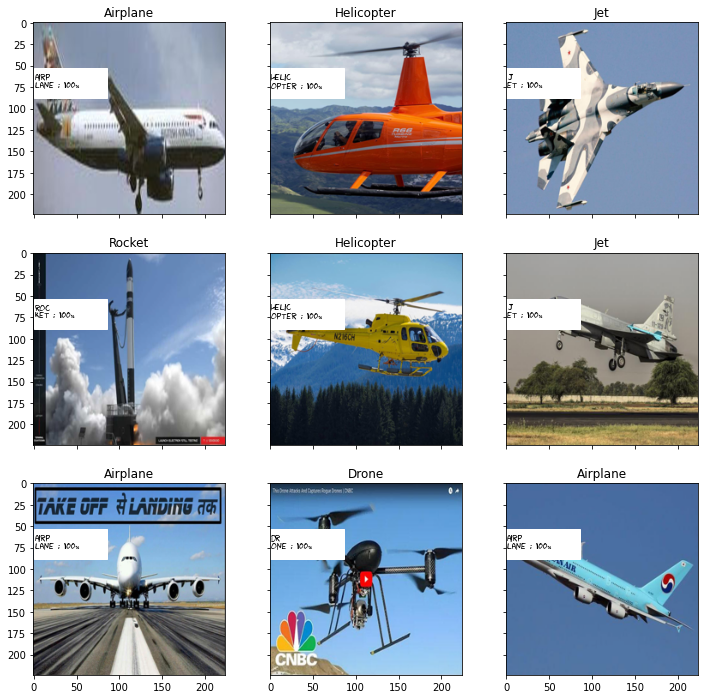

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,200))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submission

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = PlanesDataset(test_files, mode="test", augmentations=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name.split('.')[0] for path in test_dataset.files]

In [ ]:
submit = pd.DataFrame({'id_image': test_filenames, 'label': preds})
submit.head()

id_image       label
0  ABlOlXVIuGIDCpoT      rocket
1  AErddJMswOyhbBWO  helicopter
2  AJpjISmpEQVIJeNw      rocket
3  ANNgPwweGzZpyMLC       drone
4  ASyVcErZvWjBztpE       drone

In [ ]:
submit.to_csv('submission.csv', index=False)

В итоге мы обучили сетку и создали файл с предсказанными классами для тестовых данных. Далее жмякаем на "Save version", выбираем, чтоб сохранилось с аутпутом, и сохрвняем нашу версию ноутбука с полученными результатами. 

![image.png](attachment:image.png)

После того, как сохранение завершится, переходим во Вьювер, скролим сниз до Output. Кликаем на созданный нами файл submission.csv и саблитим ответ (кнопка Сабмит).

![image.png](attachment:image.png)

Появится результат точности вашей модельки. Радуемся сеточной и работаем над ее улучшением)

Возможные методы оптимизации:
> 
- Схема текущей модели (помимо того, что уже использовали при построении слоев, почитай еще про:)
- - **батч-нормализацию** 
- - предотвращает искажение данных тем, что нормализует входные данные так, чтобы получить матожидание=0 и дисперсию=1 (в путорче BatchNorm2d/BatchNorm1d) 
- - **дропаут** 
- -  предотвращает переобучение тем,что отключает некоторое количество нейронов на разных итерациях во время обучениия (в путорче Dropout)
* Добавляем аугментаций
* Обязательно играем с параметрами
* Оптимизируем learning rate, batch size и вот это всё


Albumentations

https://github.com/albumentations-team/albumentations#how-to-use

![image.png](attachment:image.png)